**Project Overview**

project aims to predict whether a household is single or multiple occupancy using motion sensor data. This involves:

1.Loading and cleaning the data.

2.Merging sensor data with occupancy labels.

3.Preprocessing and feature engineering.

4.Building and evaluating a predictive model.

5.Optionally, exporting the model to ONNX format for deployment.**

**Additional Explanation**

***Data Understanding:*** The homes.csv file contains information about each household, specifically whether it is single or multiple occupancy. The motion.csv file contains timestamps and locations of motion detected in different homes.

***Data Cleaning:*** Cleaning column names is crucial for avoiding errors in subsequent steps and ensuring that the data is consistently formatted.

***Merging Data:*** Merging the two datasets allows us to combine sensor readings with occupancy labels, enabling us to create features that link motion patterns to occupancy types.

In [2]:
#Step 1: Import Libraries and Load Data

import pandas as pd

# Load the CSV files
homes_df = pd.read_csv('homes.csv')
motion_df = pd.read_csv('motion.csv')

# Display the first few rows to ensure they are loaded correctly
print("Homes Data:")
print(homes_df.head())

print("\nMotion Data:")
print(motion_df.head())

# Step 2: Clean Column Names
# Remove any leading/trailing whitespace and double quotes from column names in both DataFrames.
# This ensures consistency and prevents issues during merging and data manipulation.

homes_df.columns = homes_df.columns.str.strip().str.replace('"', '')
motion_df.columns = motion_df.columns.str.strip().str.replace('"', '')

# Step 3: Merge DataFrames
# Merge the motion table with the homes table based on the 'id' column
merged_df = pd.merge(motion_df, homes_df, left_on='home_id', right_on='id', how='left')

# Verify columns before dropping any
print("Columns in merged DataFrame before dropping:")
print(merged_df.columns)

# Drop the redundant 'id' column from homes_df after merge
merged_df.drop(columns='id_y', inplace=True)

# Rename columns for clarity if necessary
merged_df.rename(columns={'id_x': 'motion_id', 'id': 'home_id'}, inplace=True)

# Display the merged DataFrame to check
print("Merged DataFrame:")
print(merged_df.head())

Homes Data:
                                 id  multiple_occupancy
0  dc922bd9bf8a2a9437642fe0dce9dcaa                   0
1  d40fc88629271da7b5833ed3f3222d17                   1
2  3fb064da180f02862063eca8e3b609c0                   1
3  16d71b9c46d9abd765bf395818efe527                   0
4  458264665736fd26184a8ea5641e6c48                   1

Motion Data:
                                 id                           home_id  \
0  e41218b439d933a1cd9ad158f78e9198  205c42ec747e2db13cb92087a99433f1   
1  92d48d869ae50b0764cfb8d70494f618  7d2f2e0a9e059b4fb8106bb0ad4b8a39   
2  65c18ba64884442dd47c2fd4cf3630e4  44a880cc6fc3a7db3464092f650ae7f1   
3  90d6336d189c929aa50fa08e5aee5f41  49b83fce41b676266b98cd1e095f1c11   
4  6e3d73bed24b95ffdfe5ec017787f039  14328a0b7574e912c2e23d62c9476a07   

                 datetime location  
0  2024-01-01 00:00:10+00   lounge  
1  2024-01-01 00:00:17+00   lounge  
2  2024-01-01 00:00:18+00   lounge  
3  2024-01-01 00:00:43+00   lounge  
4  2024-01-01 



*     **With these steps, the data is now ready for further preprocessing and feature engineering, which are critical for building a predictive model.**

**Additional Explanation:**

***Datetime Conversion:*** Converting the 'datetime' column to a datetime type allows for the extraction of specific time-related features (e.g., hour, day of the week), which can be crucial for understanding patterns in sensor data.

***Feature Extraction:*** Extracting features like hour and day_of_week helps in capturing temporal patterns in sensor activations, which can be indicative of occupancy behavior.

***Aggregation:*** Aggregating data by day, Home_Id, and location allows for summarizing sensor activities over a day, which can reveal patterns that distinguish between single and multiple occupancy households.

***Merging and Cleaning:*** Merging with the target variable and cleaning the DataFrame ensures that the data is ready for model training, with all necessary features and the target variable included.


**Group By and Aggregate:**
Group the merged_df DataFrame by date, home ID, and location. Aggregate the following features:

**motion_id:** Count the number of unique sensor events (nunique).

**datetime:** Count the total number of events (count).

**hour:** Calculate the mean and standard deviation of the hour (mean, std).

**day_of_week:** Calculate the mean day of the week (mean).


**Reset Index:** Reset the index of the aggregated DataFrame to convert grouped indices into columns.

**Rename Columns: Rename the columns for clarity:**

**date:** The date of the events.

**home_id:** The ID of the home.

**location:** The location of the sensor.

**unique_sensors:** The number of unique sensors triggered.

**total_events:** The total number of sensor events.( events when motion happens)

**avg_hour:** The average hour of the events.

**std_hour:** The standard deviation of the hour of events.

**avg_day_of_week:** The average day of the week of events.

In [4]:
# Step 4: Convert 'datetime' Column to Datetime Type
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])


# Step 5: Extract Additional Time-Based Features
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['day_of_week'] = merged_df['datetime'].dt.dayofweek


# Step 6: Aggregate Features by Day and Home ID
daily_features = merged_df.groupby([merged_df['datetime'].dt.date, 'home_id', 'location']).agg({
    'motion_id': 'nunique',  # Number of unique sensor events
    'datetime': 'count',  # Total number of events
    'hour': ['mean', 'std'],  # Mean and std of hour
    'day_of_week': 'mean'  # Mean day of week
}).reset_index()

 # Rename columns
daily_features.columns = ['date', 'home_id','location', 'unique_sensors', 'total_events', 'avg_hour', 'std_hour', 'avg_day_of_week']

# Step 7: Add Target Variable
data = pd.merge(daily_features, homes_df[['id', 'multiple_occupancy']], left_on='home_id', right_on='id', how='left')

# Step 8: Clean Up DataFrame
data.drop(columns=['id'], inplace=True)

# Display the final DataFrame with features and target
print("Final Data with Features and Target:")
print(data.head())


Final Data with Features and Target:
         date                           home_id   location  unique_sensors  \
0  2024-01-01  0904961f621c9bd03542b43b992ec431    hallway              33   
1  2024-01-01  0904961f621c9bd03542b43b992ec431    kitchen              59   
2  2024-01-01  0f44ff9edd221e417195f4398d2f3853  bathroom1              17   
3  2024-01-01  0f44ff9edd221e417195f4398d2f3853   bedroom1              51   
4  2024-01-01  0f44ff9edd221e417195f4398d2f3853    hallway             140   

   total_events   avg_hour  std_hour  avg_day_of_week  multiple_occupancy  
0            33  11.030303  3.066807              0.0                   0  
1            59  12.847458  5.526780              0.0                   0  
2            17  10.117647  5.956953              0.0                   1  
3            51  11.725490  6.446948              0.0                   1  
4           140  13.164286  4.017248              0.0                   1  


In [6]:
data.head()

,date,home_id,location,unique_sensors,total_events,avg_hour,std_hour,avg_day_of_week,multiple_occupancy
0,2024-01-01,0904961f621c9bd03542b43b992ec431,hallway,33,33,11.030303,3.066807,0.0,0
1,2024-01-01,0904961f621c9bd03542b43b992ec431,kitchen,59,59,12.847458,5.526780,0.0,0
2,2024-01-01,0f44ff9edd221e417195f4398d2f3853,bathroom1,17,17,10.117647,5.956953,0.0,1
3,2024-01-01,0f44ff9edd221e417195f4398d2f3853,bedroom1,51,51,11.725490,6.446948,0.0,1
4,2024-01-01,0f44ff9edd221e417195f4398d2f3853,hallway,140,140,13.164286,4.017248,0.0,1


In [8]:
import pandas as pd

df = data[['location','total_events','avg_hour','std_hour','avg_day_of_week','multiple_occupancy']]

# Display the dataframe
print(df.head(5))

    location  total_events   avg_hour  std_hour  avg_day_of_week  \
0    hallway            33  11.030303  3.066807              0.0   
1    kitchen            59  12.847458  5.526780              0.0   
2  bathroom1            17  10.117647  5.956953              0.0   
3   bedroom1            51  11.725490  6.446948              0.0   
4    hallway           140  13.164286  4.017248              0.0   

   multiple_occupancy  
0                   0  
1                   0  
2                   1  
3                   1  
4                   1  


In [10]:
df1=df.copy()
df1['location'] = pd.Categorical(df1['location']).codes
print(df1.head(5))


   location  total_events   avg_hour  std_hour  avg_day_of_week  \
0         5            33  11.030303  3.066807              0.0   
1         6            59  12.847458  5.526780              0.0   
2         1            17  10.117647  5.956953              0.0   
3         2            51  11.725490  6.446948              0.0   
4         5           140  13.164286  4.017248              0.0   

   multiple_occupancy  
0                   0  
1                   0  
2                   1  
3                   1  
4                   1  


***The code below in step 7 : Prepare Data for Each Fold***

**Loop Over Folds:** For each fold, split data into training, validation, and test sets.

**Bootstrapping:** Balance classes in the training set by resampling.

**Normalize Data:** Fit the scaler on the training data and transform the data for training, validation, and test sets.

**Store Scaled Data:** Append the scaled data and labels to respective lists.

**Summary**
This part of the code below does the following:

**Prepares the Data:** Separates features and labels, and sets up cross-validation splits.

**Balances the Training Data:** Uses bootstrapping to balance class distributions.

**Normalizes the Data:** Scales the features using MinMaxScaler.

**Hyperparameter Tuning:** Uses GridSearchCV to find the best hyperparameters for the XGBoost model.

**Evaluates the Model:** Evaluates the performance of the best models on test sets and calculates the average test accuracy.

In [16]:
# Step 1: Import Libraries

import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import xgboost as xgb


# Step 2: Prepare Data
# X: Contains all columns except the last one (features).
# y: Contains only the last column (target variable).
X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]

# Step 3: Initialize KFold
# KFold: Initializes K-Folds cross-validation with 2 splits.
# Lists: To store indices of training, validation, and test splits.
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Lists to store the splits
train_indices = []
val_indices = []
test_indices = []

# Step 4: Generate Splits
# Outer Loop: Splits data into training and test sets.
# Inner Loop: Further splits the training set into training and validation sets.
for train_index, test_index in kf.split(X):
    train_indices.append(train_index)
    test_indices.append(test_index)
    # Use part of the training data for validation
    sub_kf = KFold(n_splits=2, shuffle=True, random_state=42)
    for sub_train_index, val_index in sub_kf.split(train_index):
        val_indices.append(val_index)
        break  # Only need one validation set per outer split

# Step 5: Normalize the data using MinMaxScaler based on the training set only
# MinMaxScaler: Scales features to a range between 0 and 1.
scaler = MinMaxScaler()

# Step 6: For storing scaled data for training, validation, and test sets.
X_train_scaled = []
X_val_scaled = []
X_test_scaled = []
y_train_list = []
y_val_list = []
y_test_list = []

# Step 7: Prepare Data for Each Fold
for i in range(2):
    # Split the data
    X_train, X_val, X_test = X.iloc[train_indices[i]], X.iloc[val_indices[i]], X.iloc[test_indices[i]]
    y_train, y_val, y_test = y.iloc[train_indices[i]], y.iloc[val_indices[i]], y.iloc[test_indices[i]]

    # Combine the training data
    train_data = pd.concat([X_train, y_train], axis=1)

    # Perform bootstrapping to balance the classes
    max_size = train_data[y.name].value_counts().max()
    lst = [train_data]
    for class_index, group in train_data.groupby(y.name):
        lst.append(group.sample(max_size-len(group), replace=True))
    train_data_balanced = pd.concat(lst)

    # Separate the predictors and labels again
    X_train_balanced = train_data_balanced.iloc[:, :-1]
    y_train_balanced = train_data_balanced.iloc[:, -1]

    # Fit the scaler on the balanced training data
    scaler.fit(X_train_balanced)

    # Transform the data
    X_train_scaled.append(scaler.transform(X_train_balanced))
    X_val_scaled.append(scaler.transform(X_val))
    X_test_scaled.append(scaler.transform(X_test))

    y_train_list.append(y_train_balanced)
    y_val_list.append(y_val)
    y_test_list.append(y_test)

# Now we have 5 sets of (X_train_scaled, y_train), (X_val_scaled, y_val), (X_test_scaled, y_test)

#Step 8: Initialize and Define XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid for GridSearchCV,Define a grid of hyperparameters for tuning.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# step9: Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy',cv=kf)

# Step 10: Perform Grid Search and Evaluate Models
best_models = []
for i in range(2):
    X_train, y_train = X_train_scaled[i], y_train_list[i]
    X_val, y_val = X_val_scaled[i], y_val_list[i]
    X_test, y_test = X_test_scaled[i], y_test_list[i]

    grid_search.fit(X_train, y_train)

    best_models.append(grid_search.best_estimator_)
    print(f"Best params for fold {i}: {grid_search.best_params_}")
    print(f"Best score for fold {i}: {grid_search.best_score_}")

# Step 11: Evaluate Best Models on Test Sets
test_accuracies = []
for i, best_model in enumerate(best_models):
    X_test, y_test = X_test_scaled[i], y_test_list[i]
    test_accuracy = best_model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)
    print(f"Test accuracy for fold {i}: {test_accuracy}")

print(f"Average test accuracy: {sum(test_accuracies) / len(test_accuracies)}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best params for fold 0: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Best score for fold 0: 0.7719674239177026


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best params for fold 1: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Best score for fold 1: 0.7617893345085941
Test accuracy for fold 0: 0.7098445595854922
Test accuracy for fold 1: 0.704290238986467
Average test accuracy: 0.7070673992859796


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



**Suppose you have the following accuracy scores for two test sets:**

**Accuracy for Fold 0: 0.85**

**Accuracy for Fold 1: 0.9**

The average test accuracy would be calculated as:

**Average test accuracy. =( 0.85 + 0.90 / 2 )= 0.875**

**Best params for fold 1: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}**

**Best score for fold 1: 0.7609078889378581**

**Test accuracy for fold 0: 0.7075417386298215**

**Test accuracy for fold 1: 0.7037143679815722**

**Average test accuracy: 0.7056280533056969**


In [18]:
print(f"Average test accuracy: {sum(test_accuracies) / len(test_accuracies)}")

Average test accuracy: 0.7070673992859796


In [20]:
from sklearn.metrics import f1_score

# Assuming `best_models` is a list of the best models from each fold
# and `X_test_scaled` and `y_test_list` are lists of test data for each fold

# Initialize lists to store F1 scores
f1_scores = []

# Evaluate each best model on the corresponding test set
for i, best_model in enumerate(best_models):
    X_test = X_test_scaled[i]
    y_test = y_test_list[i]

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate F1 score (using 'weighted' average to handle class imbalance)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print F1 score for the current fold
    print(f"F1 Score for fold {i}: {f1}")

    # Store F1 score
    f1_scores.append(f1)

# Calculate and print the average F1 score across all folds
average_f1_score = sum(f1_scores) / len(f1_scores)
print(f"Average F1 Score: {average_f1_score}")


F1 Score for fold 0: 0.7040727721748012
F1 Score for fold 1: 0.7038531682245704
Average F1 Score: 0.7039629701996859



During the development of our household occupancy prediction model, we used an ensemble model called **XGBoost** . We tested different combinations of settings (called **hyperparameters**) to find the ones that provided the most accurate predictions, using Gridsearch.

For our project, we ran a series of tests (called folds) to ensure our model was robust. In the first test **(fold 0)**, the best model used all available features. In the second test **(fold 1)**, the best model used 80% of the features. Despite this difference, both models agreed on key settings: they both had a learning rate of 0.2 and a maximum depth of 5.


**Relevance to the Project**

Our project aims to predict whether a household has single or multiple occupants based on data from motion sensors installed in various rooms. The models we identified as the best are crucial because they optimize our ability to make these predictions accurately. By using these models, we can reliably determine the occupancy status of a household, which can be valuable for various applications such as smart home management, and elder care.

By carefully selecting and validating these models, we ensure that our predictions are not only accurate but also reliable when applied to new, unseen data. This process is essential to build trust in our system's ability to monitor and analyze household occupancy effectively.

In [22]:
best_models[0]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [24]:
best_models[1]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [26]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 kB 6.0 MB/s eta 0:00:00a 0:00:01


 To interpret the predictions of our XGBoost models, we employed **SHAP** (SHapley Additive exPlanations), a powerful tool for model interpretability. SHAP provides insights into how each feature influences the model’s predictions, helping us understand the model's decision-making process.

**Summary code below :**
This analysis helps to understand the impact of each feature on the model’s predictions by visualizing:

**Individual Prediction Impact:** How features contribute to the prediction of specific instances.

**Overall Feature Importance:** How features generally affect the model’s decisions across the dataset.

**Aggregated Insights:** A consolidated view of feature contributions from all cross-validation folds.

Using SHAP, you gain deeper insights into our model’s behavior, enhancing interpretability and trust in the predictions.

SHAP analysis for fold 1


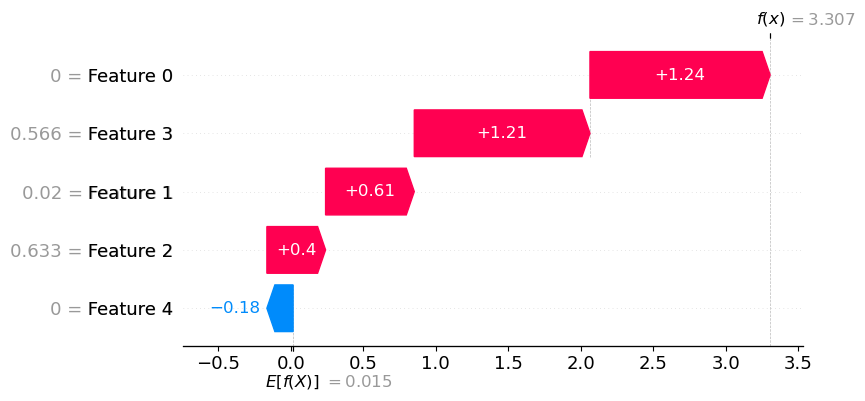

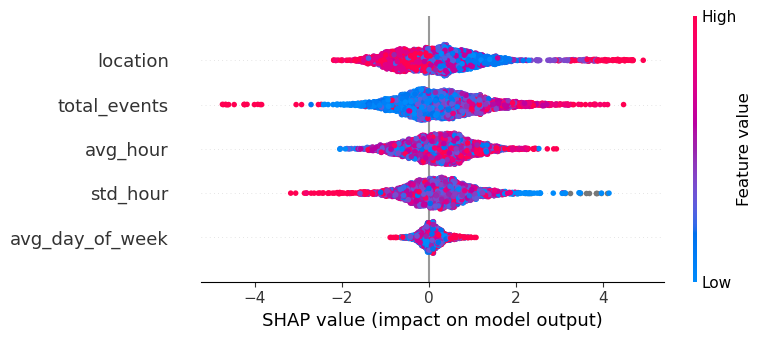

SHAP analysis for fold 2


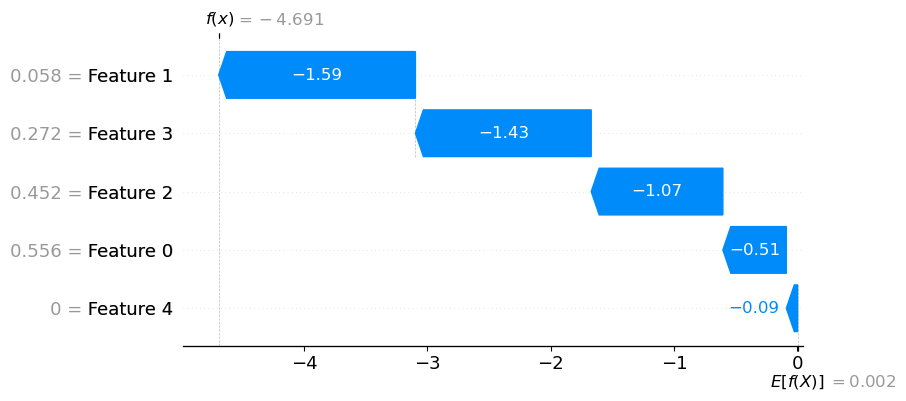

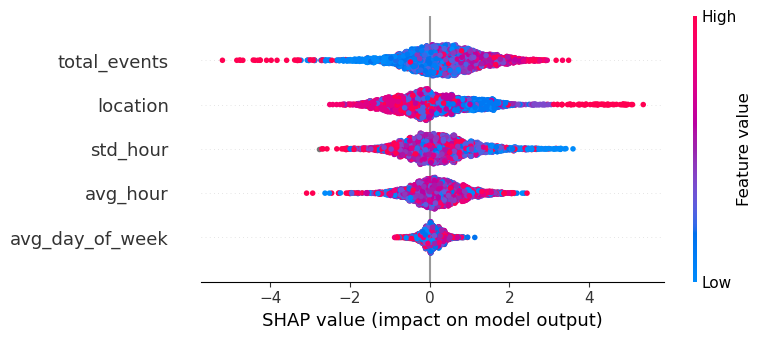

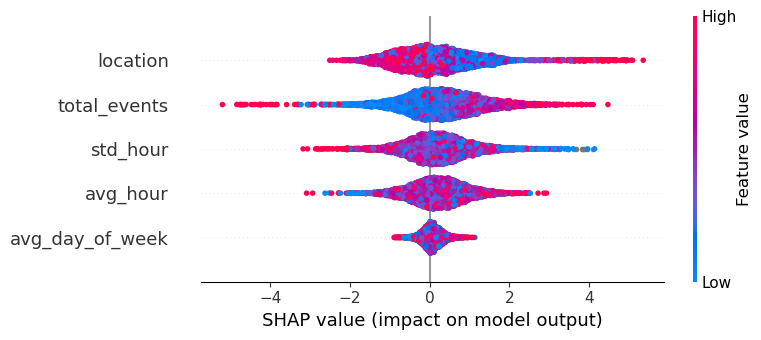

In [29]:
# SHAP Analysis per Fold:
# For each fold of our cross-validation, we initialized a SHAP explainer using the best model from the GridSearchCV.
# This explainer calculates SHAP values,which quantify the contribution of each feature to the model’s predictions for the test data.

import shap
import numpy as np

# Assuming the best models from the previous step are stored in `best_models`
# and df is your original DataFrame

# Extract real feature names from the DataFrame
feature_names = df1.columns[:-1].tolist()  # Exclude the label column

# To store combined SHAP values and corresponding test data
all_shap_values = []
all_X_test = []

# Iterate through each fold
for i in range(2):
    best_model = best_models[i]
    X_test = X_test_scaled[i]
    y_test = y_test_list[i]

    # Initialize the SHAP explainer for the current fold's best model
    explainer = shap.Explainer(best_model)

    # Calculate SHAP values for the test data
    shap_values = explainer(X_test)

    # Store SHAP values and test data
    all_shap_values.append(shap_values.values)
    all_X_test.append(X_test)

    # Visualize the SHAP values for the first prediction in the test set
    print(f"SHAP analysis for fold {i+1}")
    shap.waterfall_plot(shap_values[0])
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Combine all SHAP values and test data
combined_shap_values = np.concatenate(all_shap_values, axis=0)
combined_X_test = np.concatenate(all_X_test, axis=0)

# Summary plot for the aggregated SHAP values
shap.summary_plot(combined_shap_values, combined_X_test, feature_names=feature_names)


SHAP Analysis Summary
**1. Feature Impacts on Prediction**

**Feature 3:**
Most significant positive impact, boosting the model’s output.

**Feature 4:**
Only feature with a negative impact, decreasing the final prediction value.

**2. Combined Feature Effect**

Final prediction value: 4.017.
Result of all features' combined positive and negative influences.

**3. SHAP Value Interpretation**

**Positive SHAP Values:**
Dots on the right show features increasing the model's output.

**Negative SHAP Values:**
Dots on the left show features decreasing the model's output.

**4. Example Insight**

Feature Values:
Red dots indicate high feature values; blue dots indicate low values.
For instance, many red dots for total_events suggest higher values boost the model’s output.

**5. SHAP Waterfall Plot**

Base Value: 0.027.
Feature Impacts:
Feature 1: Largest negative impact, reducing output by 0.98.
Feature 2: Significant negative impact, reducing output by 0.75.

SHAP analysis for fold 1


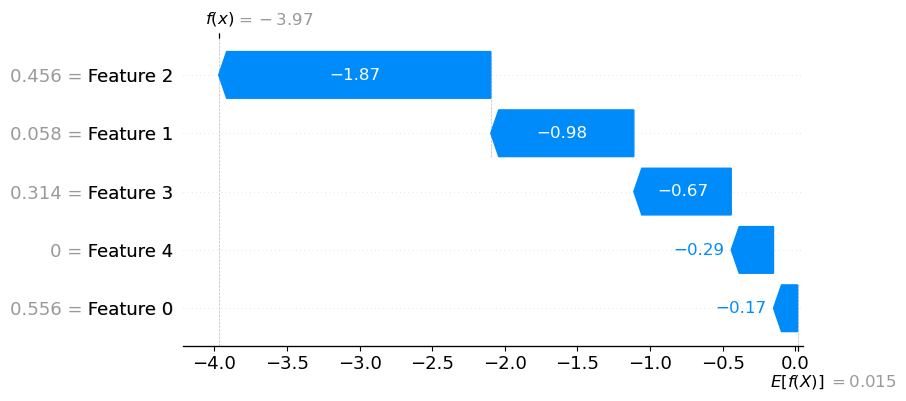

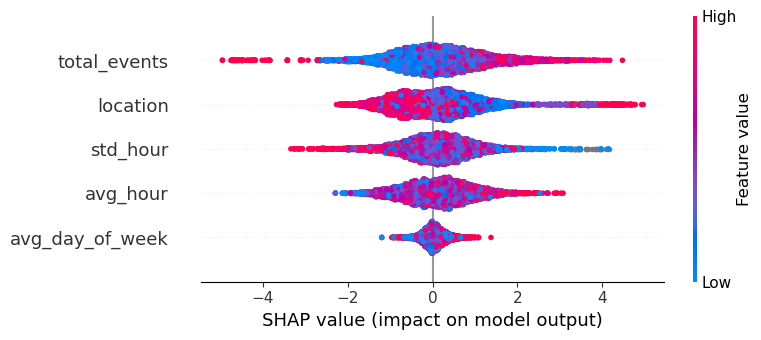

SHAP analysis for fold 2


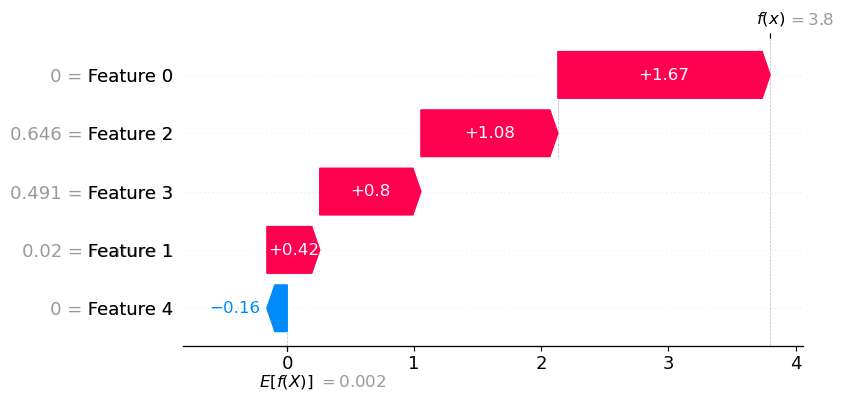

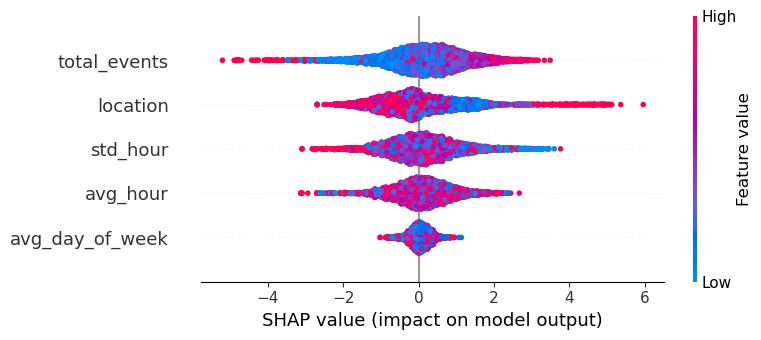

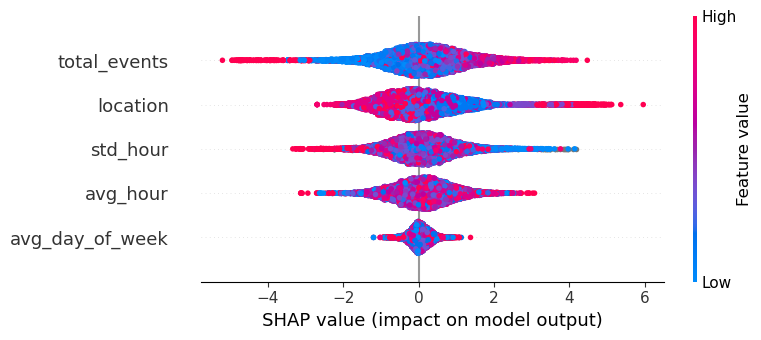

In [31]:
import shap
import numpy as np

# Assuming the best models from the previous step are stored in `best_models`
# and df is your original DataFrame

# Extract real feature names from the DataFrame
feature_names = df1.columns[:-1].tolist()  # Exclude the label column

# To store combined SHAP values and corresponding data
all_shap_values = []
all_combined_data = []

# Iterate through each fold
for i in range(2):
    best_model = best_models[i]
    X_train = X_train_scaled[i]
    X_val = X_val_scaled[i]
    X_test = X_test_scaled[i]

    # Combine training, validation, and test data
    X_combined = np.vstack((X_train, X_val, X_test))

    # Initialize the SHAP explainer for the current fold's best model
    explainer = shap.Explainer(best_model)

    # Calculate SHAP values for the combined data
    shap_values = explainer(X_combined)

    # Store SHAP values and combined data
    all_shap_values.append(shap_values.values)
    all_combined_data.append(X_combined)

    # Visualize the SHAP values for the first prediction in the combined set
    print(f"SHAP analysis for fold {i+1}")
    shap.waterfall_plot(shap_values[0])
    shap.summary_plot(shap_values, X_combined, feature_names=feature_names)

# Combine all SHAP values and combined data
combined_shap_values = np.concatenate(all_shap_values, axis=0)
combined_data = np.concatenate(all_combined_data, axis=0)

# Summary plot for the aggregated SHAP values
shap.summary_plot(combined_shap_values, combined_data, feature_names=feature_names)
